# Deep Q-learning using TAGIV on small grdiworld

In [1]:
import os
os.chdir("..")
from src.gym_kalman.env_Gridworld import GridworldEnv
from pytagi.nn import Linear, OutputUpdater, ReLU, Sequential, EvenExp

In [2]:
# Initialize value function
import numpy as np

reward_mean = -1
reward_std = 0.2

# initialize the environment
grid_size = 4
env = GridworldEnv(grid_size=grid_size, reward_mean=reward_mean, reward_std=reward_std)
num_states = env.observation_space.n
actions = np.arange(env.action_space.n)

In [3]:
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    # "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [4]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [5]:
class TAGI_Net():
    def __init__(self, n_observations, n_actions):
        super(TAGI_Net, self).__init__()
        self.net = Sequential(
                    Linear(n_observations, 128),
                    ReLU(),
                    Linear(128, 128),
                    ReLU(),
                    Linear(128, n_actions * 2),
                    EvenExp()
                    )
        self.n_actions = n_actions
        self.n_observations = n_observations
    def forward(self, mu_x, var_x):
        return self.net.forward(mu_x, var_x)

In [6]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 1

TAU = 0.005
LR = 1e-2

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = 16

policy_net = TAGI_Net(n_observations, n_actions)
target_net = TAGI_Net(n_observations, n_actions)
target_net.net.load_state_dict(policy_net.net.get_state_dict())

memory = ReplayMemory(10000)

steps_done = 0

# # Thompson Sampling
# def select_action(state):
#     global steps_done
#     steps_done += 1
#     policy_net.net.eval()
#     state_np = state.numpy()

#     state_temp = np.array(state_np)
#     state_np = np.repeat(state_temp, BATCH_SIZE, axis=0)

#     ma, Sa = policy_net.net(state_np)
#     ma = ma.reshape(BATCH_SIZE, policy_net.n_actions*2)
#     ma = ma[0]
#     action_mean = ma[::2]
#     Sa = Sa.reshape(BATCH_SIZE, policy_net.n_actions*2)[0]
#     action_var = Sa[::2] + ma[1::2]

#     a_sample = np.zeros_like(action_mean)
#     # print(state)
#     for i in range(len(action_mean)):
#         a_sample[i] = np.random.normal(action_mean[i], np.sqrt(action_var[i]))

#     action = np.argmax(a_sample, axis=0)

#     steps_done += 1
#     return torch.tensor([[action]],device=device)

# Greedy
EPS_START = 0.9
EPS_END = 0.0001
EPS_DECAY = 1000
def select_action(state):
    global steps_done

    policy_net.net.eval()
    state_np = state.numpy()

    state_temp = np.array(state_np)
    state_np = np.repeat(state_temp, BATCH_SIZE, axis=0)

    ma, Sa = policy_net.net(state_np)
    ma = ma.reshape(BATCH_SIZE, policy_net.n_actions*2)
    ma = ma[0]
    action_mean = ma[::2]
    Sa = Sa.reshape(BATCH_SIZE, policy_net.n_actions*2)[0]
    action_var = Sa[::2] + ma[1::2]

    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        action = np.argmax(action_mean, axis=0)
    else:
        action = np.random.randint(0, n_actions)

    return torch.tensor([[action]],device=device)

def select_greedy_action(state):
    global steps_done
    steps_done += 1
    policy_net.net.eval()
    state_np = state.numpy()

    state_temp = np.array(state_np)
    state_np = np.repeat(state_temp, BATCH_SIZE, axis=0)

    ma, _ = policy_net.net(state_np)
    ma = ma.reshape(BATCH_SIZE, policy_net.n_actions*2)[0]
    action_mean = ma[::2]

    action = np.argmax(action_mean, axis=0)

    return torch.tensor([[action]],device=device)

In [7]:
def normalize_state(state):
    if state == None:
        return None
    else:
        return state / 15

def denormalize_state(state):
    if state == None:
        return None
    else:
        return state * 15

def normalize_reward(reward):
    return reward / 6

def denormalize_reward(reward):
    return reward * 6

def state_encoder(state):
    # one hot encoding
    state_onehot = np.zeros(num_states)
    state_onehot[state] = 1
    return state_onehot

def state_decoder(state_onehot):
    return np.argmax(state_onehot)

In [8]:
def infer_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    policy_net.net.train()
    target_net.net.eval()

    final_mask = torch.tensor(tuple(map(lambda s: s is None,
                                batch.next_state)), device=device, dtype=torch.bool)

    state_mean_batch = torch.cat(batch.state).numpy()
    action_batch = torch.cat(batch.action).numpy()
    reward_batch = torch.cat(batch.reward).numpy()
    # next_state_mean_batch = torch.cat([s if s is not None
    #                                     else torch.tensor([100.0])
    #                                     for s in batch.next_state]).numpy()

    next_state_mean_batch = torch.cat([s if s is not None
                                        else torch.tensor([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
                                                           0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
                                        for s in batch.next_state]).numpy()

    # Add uncertainty to the state
    state_batch = {'mu': state_mean_batch, 'var': np.zeros_like(state_mean_batch)}
    next_state_batch = {'mu': next_state_mean_batch, 'var': np.zeros_like(next_state_mean_batch)}

    # Get the next state values from target net
    next_state_values_mu_f, next_state_values_var_f = target_net.net(next_state_batch['mu'])

    # Reshape to 2D
    next_state_values_mu_f = next_state_values_mu_f.reshape(BATCH_SIZE, target_net.n_actions*2)
    next_state_values_var_f = next_state_values_var_f.reshape(BATCH_SIZE, target_net.n_actions*2)

    # Along the first axis, select the first and the third columns of the 2D array next_state_values_mu
    next_state_values_mu = next_state_values_mu_f[:, [0, 2, 4, 6]]
    next_state_values_var = next_state_values_var_f[:, [0, 2, 4, 6]] + next_state_values_mu_f[:, [1, 3, 5, 7]]

    # next_state_values_samples = np.zeros((BATCH_SIZE, target_net.n_actions))
    # for i in range(BATCH_SIZE):
    #     for j in range(target_net.n_actions):
    #         next_state_values_samples[i, j] = np.random.normal(next_state_values_mu[i, j], np.sqrt(next_state_values_var[i, j]))

    # # Keep the maximum next state value according to the samples
    # max_indices = np.argmax(next_state_values_samples, axis=1)
    # Greedy action selection

    max_indices = np.argmax(next_state_values_mu, axis=1)

    next_state_values_mu = next_state_values_mu[np.arange(BATCH_SIZE), max_indices]
    next_state_values_var = next_state_values_var[np.arange(BATCH_SIZE), max_indices]

    # Set the next state values of final states to 0 if next state is final
    next_state_values_mu_tensor = torch.tensor(next_state_values_mu, device=device)
    next_state_values_var_tensor = torch.tensor(next_state_values_var, device=device)
    next_state_values_mu_tensor[final_mask] = 0.0
    next_state_values_var_tensor[final_mask] = 1e-4
    next_state_values_mu = next_state_values_mu_tensor.numpy()
    next_state_values_var = next_state_values_var_tensor.numpy()

    # Compute the expected Q values
    expected_state_values_mu = np.array((next_state_values_mu * GAMMA) + reward_batch)
    expected_state_values_var = np.array((next_state_values_var * GAMMA**2))

    # Infer the policy network using the expected Q values
    expected_state_action_values_mu_f, expected_state_action_values_var_f = policy_net.net(state_batch['mu'])

    # # Only change the expected Q values where actions are taken
    expected_state_action_values_mu_f = expected_state_action_values_mu_f.reshape(BATCH_SIZE, policy_net.n_actions*2)
    expected_state_action_values_var_f = expected_state_action_values_var_f.reshape(BATCH_SIZE, policy_net.n_actions*2)
    expected_state_action_values_mu = expected_state_action_values_mu_f[:, [0,2,4,6]]
    expected_state_action_values_var = expected_state_action_values_var_f[:, [0,2,4,6]] + expected_state_action_values_mu_f[:, [1,3,5,7]]
    expected_state_action_values_mu[np.arange(BATCH_SIZE), action_batch.flatten()] = expected_state_values_mu
    expected_state_action_values_var[np.arange(BATCH_SIZE), action_batch.flatten()] = expected_state_values_var
    # expected_state_action_values_mu[np.arange(self.batchsize), 1-action_batch.flatten()] = np.nan
    # expected_state_action_values_var[np.arange(BATCH_SIZE), 1-action_batch.flatten()] = 1e2

    expected_state_action_values_mu = expected_state_action_values_mu.flatten()
    expected_state_action_values_var = expected_state_action_values_var.flatten()

    # Update output layer
    out_updater = OutputUpdater(policy_net.net.device)
    out_updater.update_heteros(
        output_states = policy_net.net.output_z_buffer,
        mu_obs = expected_state_action_values_mu,
        var_obs = expected_state_action_values_var,
        delta_states = policy_net.net.input_delta_z_buffer,
    )

    # Feed backward
    policy_net.net.backward()
    policy_net.net.step()

    # For numerical stability: clip the variance of the parameters to 1e-8
    policy_net_param_temp = policy_net.net.get_state_dict()
    for key in policy_net_param_temp:
        policy_net_param_temp[key]['var_w']=np.clip(policy_net_param_temp[key]['var_w'], 1e-8, None).tolist()
        policy_net_param_temp[key]['var_b']=np.clip(policy_net_param_temp[key]['var_b'], 1e-8, None).tolist()
        # Clip the policy_net_param_temp[key]['mu_w'] at 1e8 if it is possitive and -1e8 if it is negative
        # policy_net_param_temp[key]['mu_w']=np.sign(policy_net_param_temp[key]['mu_w'])*np.clip(np.abs(policy_net_param_temp[key]['mu_w']), 1e-8, None).tolist()
        # policy_net_param_temp[key]['mu_b']=np.sign(policy_net_param_temp[key]['mu_b'])*np.clip(np.abs(policy_net_param_temp[key]['mu_b']), 1e-8, None).tolist()
    policy_net.net.load_state_dict(policy_net_param_temp)

In [9]:
# Extract current policy
def extract_policy(num_states, episode_i):
    policy = np.zeros(num_states)
    for state in range(num_states):
        if state == 15:  # Terminal state
            policy[state] = 10
            continue
        norm_state = state_encoder(state)
        state_tensor = torch.tensor(norm_state, dtype=torch.float32, device=device).unsqueeze(0)
        suggested_action = select_greedy_action(state_tensor)
        policy[state] = suggested_action

    policy_grid = np.array(policy).reshape((grid_size, grid_size))
    # Print title of the plot
    print(f"Episode {episode_i}'s policy")
    print(policy_grid)
    return

true_values_grid = np.array([-6, -5, -4, -3,
                              -5, -4, -3, -2,
                              -4, -3, -2, -1,
                              -3, -2, -1, 0.0]).reshape((grid_size, grid_size))

true_values_std_grid = np.array([0.49, 0.45, 0.4, 0.35,
                                 0.45, 0.4, 0.35, 0.28,
                                 0.4, 0.35, 0.28, 0.2,
                                 0.35, 0.28, 0.2, 0.0]).reshape((grid_size, grid_size))

def plot_value_distribution(episode_i, state_trace, finished=False):
    values = np.zeros(num_states)
    values_var = np.zeros(num_states)
    policy_net.net.eval()
    for state in range(num_states):
        if state == 15:  # Terminal state
            continue
        norm_state = state_encoder(state)
        state_tensor = torch.tensor(norm_state, dtype=torch.float32, device=device).unsqueeze(0)
        suggested_action = select_greedy_action(state_tensor)

        state_np = state_tensor.numpy()

        state_temp = np.array(state_np)
        state_np = np.repeat(state_temp, BATCH_SIZE, axis=0)

        mQ, sQ = policy_net.net(state_np)
        mQ = mQ.reshape(BATCH_SIZE, policy_net.n_actions*2)[0]
        sQ = sQ.reshape(BATCH_SIZE, policy_net.n_actions*2)[0]
        Q_mean = mQ[::2]
        Q_var = sQ[::2] + mQ[1::2]

        values[state] = denormalize_reward(Q_mean[suggested_action])
        values_var[state] = Q_var[suggested_action] * 6**2

    value_grid = np.array(values).reshape((grid_size, grid_size))
    value_std_grid = np.sqrt(np.array(values_var)).reshape((grid_size, grid_size))
    value_grid = np.round(value_grid, 2)

    # Set the grid to zero if it is not in the trace
    visited_grid = np.zeros((grid_size, grid_size))
    for i in range(4):
        for j in range(4):
            if i*4 + j in state_trace:
                visited_grid[i, j] = 1

    x = np.linspace(-7, 1, 50)
    # Plot 16 gaussian curves in a 4 by 4 grid
    plt.figure(1)
    if not finished:
        plt.clf()
        plt.suptitle(f"Episode {episode_i+1}: state value distribution")
    else:
        plt.suptitle(f"Sate value distribution")

    for i in range(4):
        for j in range(4):
            plt.subplot(4, 4, i*4+j+1)
            # Set the background color of the plot to gray if it is not in the trace grid
            if visited_grid[i, j] == 0:
                plt.gca().set_facecolor('lightgrey')
            if i*4 + j != 15:
                plt.title("")
                if i*4 + j == 0:
                    plt.xlabel("Start", fontsize=8)
                plt.plot(x, 1/(true_values_std_grid[i, j] * np.sqrt(2 * np.pi)) *
                            np.exp( - (x - true_values_grid[i, j])**2 / (2 * true_values_std_grid[i, j]**2) ),
                            linewidth=2, color='r', label='True')
                plt.plot(x, 1/(value_std_grid[i, j] * np.sqrt(2 * np.pi)) *
                            np.exp( - (x - value_grid[i, j])**2 / (2 * value_std_grid[i, j]**2) ),
                            linewidth=2, color='g', label='Estimated')

            else:
                plt.plot(x+10, 10+1/(true_values_std_grid[0, 0] * np.sqrt(2 * np.pi)) *
                            np.exp( - (x - true_values_grid[0, 0])**2 / (2 * true_values_std_grid[0, 0]**2) ),
                            linewidth=2, color='r', label='True')
                plt.plot(x+10, 10+1/(value_std_grid[0, 0] * np.sqrt(2 * np.pi)) *
                            np.exp( - (x - value_grid[0, 0])**2 / (2 * value_std_grid[0, 0]**2) ),
                            linewidth=2, color='g', label='Estimated')
                plt.gca().set_facecolor('yellow')
                plt.xlabel("Goal", fontsize=8)
            plt.xlim(-7, 1)
            plt.xticks([])
            plt.yticks([])
    plt.legend(['True', 'Pred'], loc='upper right')
    plt.pause(0.001)
    from IPython import display
    if not finished:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())
    return


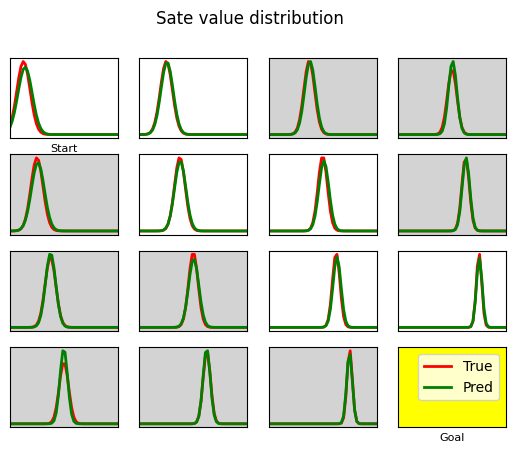

<Figure size 640x480 with 0 Axes>

Complete


<Figure size 640x480 with 0 Axes>

In [10]:
num_episodes = 600

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    # state = normalize_state(state)
    state = state_encoder(state)
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    state_trace = []
    for t in count():
        # Track the grid that the agent has visited
        state_trace.append(state_decoder(state.tolist()[0]))

        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        # observation = normalize_state(observation)
        observation = state_encoder(observation)
        reward = normalize_reward(reward)

        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        infer_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.net.get_state_dict()
        policy_net_state_dict = policy_net.net.get_state_dict()
        for key in policy_net_state_dict:
            for key2 in policy_net_state_dict[key]:
                target_net_state_dict[key][key2] = (np.asarray(policy_net_state_dict[key][key2])*TAU +
                                                    np.asarray(target_net_state_dict[key][key2])*(1-TAU)).tolist()
        target_net.net.load_state_dict(target_net_state_dict)

        if done:
            break

    # Remove the repeated grids in the grid trace
    state_trace = list(dict.fromkeys(state_trace))

    if i_episode % 1 == 0:
        plot_value_distribution(i_episode, state_trace)
    if i_episode == num_episodes - 1:
        plot_value_distribution(i_episode, state_trace, finished=True)

    # Extract policy
    # extract_policy(num_states, i_episode)

print('Complete')

In [11]:
# Extract policy
extract_policy(num_states, i_episode)

Episode 599's policy
[[ 1.  3.  1.  1.]
 [ 3.  3.  1.  1.]
 [ 1.  3.  1.  1.]
 [ 3.  3.  3. 10.]]


In [12]:
values = np.zeros(num_states)
values_var = np.zeros(num_states)
policy_net.net.eval()
for state in range(num_states):
    if state == 15:  # Terminal state
        continue
    norm_state = state_encoder(state)
    state_tensor = torch.tensor(norm_state, dtype=torch.float32, device=device).unsqueeze(0)
    suggested_action = select_greedy_action(state_tensor)

    state_np = state_tensor.numpy()

    state_temp = np.array(state_np)
    state_np = np.repeat(state_temp, BATCH_SIZE, axis=0)

    mQ, sQ = policy_net.net(state_np)
    mQ = mQ.reshape(BATCH_SIZE, policy_net.n_actions*2)[0]
    sQ = sQ.reshape(BATCH_SIZE, policy_net.n_actions*2)[0]
    Q_mean = mQ[::2]
    Q_var = sQ[::2] + mQ[1::2]

    values[state] = denormalize_reward(Q_mean[suggested_action])
    values_var[state] = Q_var[suggested_action] * 6**2

value_grid = np.array(values).reshape((grid_size, grid_size))
value_std_grid = np.sqrt(np.array(values_var)).reshape((grid_size, grid_size))
value_grid = np.round(value_grid, 2)
# value_var_grid = np.round(value_var_grid, 2)
print("\nState values:")
print(value_grid)
print("\nState values std:")
print(value_std_grid)


State values:
[[-5.88 -4.95 -3.94 -2.96]
 [-4.93 -3.97 -2.91 -1.97]
 [-3.99 -2.97 -1.94 -0.98]
 [-3.01 -2.01 -1.01  0.  ]]

State values std:
[[0.53086273 0.45527517 0.40243462 0.31066921]
 [0.48186906 0.42207969 0.37421095 0.28069834]
 [0.3780945  0.38269558 0.29722961 0.21455774]
 [0.28625252 0.26864176 0.20919169 0.        ]]
